# Rank loans by the expected ROI

This notebook ranks loans by the expected return on investment (ROI), so lenders can choose which loans to fund. It uses models to (1) predicted the probability of default (using a calibrated classifier), and to (2) predict the fraction the borrower will pay back if the borrower at some time defaults (using regression). The default probability is non-stationary, so we will use models trained on data from different years to evaluate the quality of the model.

The probability of default model is reasonably accurate. However, the regression model for the fraction the borrower pays back in case of default is no better than simply taking the mean fraction (there is very little information in the data), so we just take the mean fraction (frac(X)=0.417) as our regression model. 

In [1]:
%pylab inline

from __future__ import division

# Data handling
import numpy as np
import pandas as pd
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Functions for evaluating ROI and ranking loans.
import loanutilities as lu

# numpy display options
np.set_printoptions(precision=6, linewidth=110)

# Show all columns
pd.set_option('display.max_columns', None)

# Show at most 500 rows
pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import imp
imp.reload(lu)

<module 'loanutilities' from 'loanutilities.pyc'>

## Load the cleaned data and split it by year

In [3]:
df = pd.read_csv('loan_clean.csv', low_memory=False)
print df['issue_d'].min(), df['issue_d'].max()

2007-06-01 2015-12-01


In [4]:
mask_2007 = (df['issue_d']>='2007-01-01') & (df['issue_d']<'2008-01-01')
mask_2008 = (df['issue_d']>='2008-01-01') & (df['issue_d']<'2009-01-01')
mask_2009 = (df['issue_d']>='2009-01-01') & (df['issue_d']<'2010-01-01')
mask_2010 = (df['issue_d']>='2010-01-01') & (df['issue_d']<'2011-01-01')
mask_2011 = (df['issue_d']>='2011-01-01') & (df['issue_d']<'2012-01-01')
mask_2012 = (df['issue_d']>='2012-01-01') & (df['issue_d']<'2013-01-01')
mask_2013 = (df['issue_d']>='2013-01-01') & (df['issue_d']<'2014-01-01')
mask_2014 = (df['issue_d']>='2014-01-01') & (df['issue_d']<'2015-01-01')
mask_2015 = (df['issue_d']>='2015-01-01') & (df['issue_d']<'2016-01-01')

df_2007 = df[mask_2007]
df_2008 = df[mask_2008]
df_2009 = df[mask_2009]
df_2010 = df[mask_2010]
df_2011 = df[mask_2011]
df_2012 = df[mask_2012]
df_2013 = df[mask_2013]
df_2014 = df[mask_2014]
df_2015 = df[mask_2015]

df_list = [df_2007, df_2008, df_2009, df_2010, df_2011, 
           df_2012, df_2013, df_2014, df_2015]

print 'Number of loans issued each year:'
[len(df['bad_loan']) for df in df_list]

Number of loans issued each year:


[251, 1562, 4716, 8466, 14101, 43332, 55681, 50447, 18102]

## Load classifier models for each year
Each model contains: 
- Calibrated classifier
- Feature scaling object
- Data for training
- Metrics for classifier performance

In [5]:
def load_model(filename):
    """Unpickle model and associated data.
    """
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

In [6]:
model_2009 = load_model('model_2009.pkl')
model_2010 = load_model('model_2010.pkl')
model_2011 = load_model('model_2011.pkl')
model_2012 = load_model('model_2012.pkl')
model_2013 = load_model('model_2013.pkl')

print model_2009.keys()

['X_test', 'X_train', 'scaler', 'metrics_train', 'metrics_test', 'y_train', 'cal_clf', 'y_test']


## Compare loans chosen with the model to loans chosen randomly
The model predicts the probability of default and the fraction of the loan that is recovered if the borrower defaults. It then uses these values to calculate the expectation value of the amount the borrow will pay back and the corresponding ROI. The model then sorts through the available loans and chooses the ones with the highest expected ROI.

In [7]:
def predicted_roi_vs_model_year(df, model_list=[model_2009, model_2010, model_2011, model_2012, model_2013]):
    """Predict the ROI for the loans in df for each default model.
    Also calculate the ROI from the known payments (assuming that's also in the df).
    """
    # The known ROI
    payments_known = lu.total_payments_in_portfolio_known(df)
    rate_eff_known = payments_known['rate_eff']
    
    # The predicted ROI for each model
    roi = []
    for model in model_list:
        cal_clf = model['cal_clf']
        scaler = model['scaler']
        payments = lu.total_payments_in_portfolio_predicted(df, cal_clf, scaler)
        roi.append(payments['rate_eff'])
    
    return rate_eff_known, np.array(roi)

In [12]:
def compare_chosen_loans_to_random_sample(df, n, model):
    """
    """
    ###### Choose best loans ######
    
    cal_clf = model['cal_clf']
    scaler = model['scaler']
    rate, df_chosen = lu.get_highest_predicted_roi_loans(df, cal_clf, scaler, n)
    
    # Actual performance and predicted performance
    r_known_chosen, r_chosen = predicted_roi_vs_model_year(df_chosen)
    
    ###### Randomly sample from loans ######
    
    df_sample = df.sample(n)

    # Actual performance and predicted performance
    r_known_sample, r_sample = predicted_roi_vs_model_year(df_sample)

    ###### Plot difference between best loans and random sample ######
    
    year_list=[2009, 2010, 2011, 2012, 2013]
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(year_list, r_chosen*100, c='b', label='Chosen to maximize ROI')
    ax.axhline(r_known_chosen*100, c='b', ls='--', label='True ROI from chosen')
    ax.plot(year_list, r_sample*100, c='orange', label='Sampled at random')
    ax.axhline(r_known_sample*100, c='orange', ls='--', label='True ROI from sampled')
    ax.legend()
    ax.set_xlabel('Year model was trained on')
    ax.set_ylabel('Predicted ROI (%)')
    ax.set_xticks(year_list)
    ax.minorticks_on()
    ax.set_ylim(-10, 20)
    
    return r_known_chosen, r_chosen, df_chosen

### Example 1: Rank loans using a model trained on the same year as the data
 - The model is trained on 2010 data. The loans are selected from 2010.
 - The model reasonably predicts the true ROI. In reality the model must be from $\ge 3$ years before the 3-year loan is fully paid off, so this situation is not possible.

Chosen loans ranked from highest to lowest expected ROI:


,bad_loan,annual_inc,emp_length,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_amnt,int_rate,installment,issue_d,total_rec_prncp,total_rec_int,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
22423,0,79560.0,10.0,7.81,0.0,0.0,33.0,11.0,0.0,10750.0,47.1,16.0,0.0,0.0,0.0,66863.5,20900.0,8000.0,12.53,267.74,2010-01-01,8000.0,1574.07,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22436,0,191000.0,1.0,12.20,0.0,0.0,49.0,16.0,0.0,444.0,2.5,54.0,0.0,0.0,0.0,66863.5,20900.0,10000.0,12.53,334.67,2010-01-01,10000.0,1604.20,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18454,0,100000.0,10.0,12.30,1.0,0.0,19.0,17.0,0.0,4784.0,15.5,36.0,0.0,0.0,0.0,66863.5,20900.0,8000.0,11.86,265.18,2010-07-01,8000.0,1378.11,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17520,0,150000.0,4.0,4.68,1.0,1.0,6.0,10.0,0.0,7062.0,21.9,35.0,0.0,0.0,0.0,66863.5,20900.0,7800.0,11.86,258.56,2010-08-01,7800.0,1506.00,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22570,0,65000.0,2.0,3.54,0.0,1.0,72.0,10.0,0.0,9514.0,27.2,15.0,0.0,0.0,0.0,66863.5,20900.0,10000.0,12.53,334.67,2010-01-01,10000.0,2040.97,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


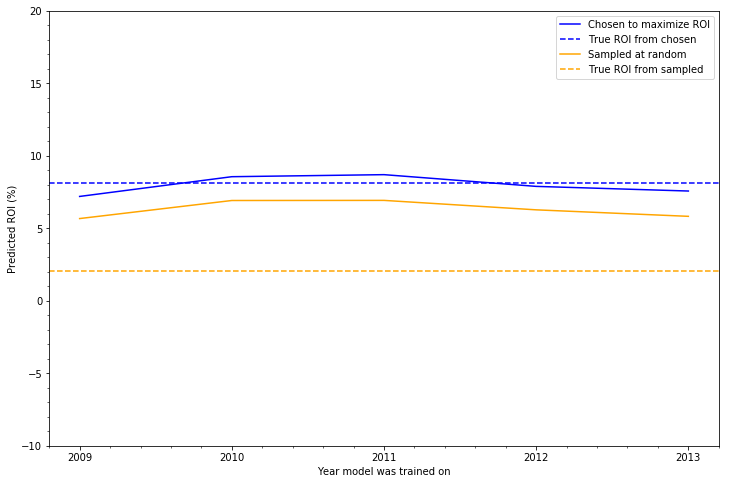

In [18]:
# Number of loans you would like to fund
n = 100

# The loans you would like to examine
df = df_2010[(df_2010['grade_B']==1)]
#df = df_2010[(df_2010['grade_B']==1)|(df_2010['grade_C']==1)]

# Model year you want to use for predicting the highest ROI loans
model = model_2010

r_known_chosen, r_chosen, df_chosen = compare_chosen_loans_to_random_sample(df, n, model)
print 'Chosen loans ranked from highest to lowest expected ROI:'
df_chosen.head()

### Example 2 (realistic case): Rank loans using a model trained on data from 3 years ago.
- The model is trained on 2010 data. The loans are selected from 2013.
- The predicted ROI is not accurate, but the model still selects better loans than a random sampling.

Chosen loans ranked from highest to lowest expected ROI:


,bad_loan,annual_inc,emp_length,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_amnt,int_rate,installment,issue_d,total_rec_prncp,total_rec_int,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
36787,0,115000.0,6.0,3.87,0.0,0.0,34.0,12.0,0.0,5257.0,27.0,32.0,0.0,0.0,273.0,302384.0,19500.0,10400.0,13.67,353.79,2013-11-01,10400.0,1150.52,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66591,0,84000.0,7.0,23.32,0.0,0.0,44.0,13.0,0.0,6308.0,27.3,34.0,0.0,0.0,0.0,84722.0,23100.0,12025.0,14.09,411.52,2013-05-01,12025.0,1476.42,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40188,0,150000.0,10.0,6.70,2.0,0.0,4.0,15.0,0.0,14580.0,28.6,28.0,0.0,0.0,0.0,393604.0,51000.0,15000.0,13.67,510.27,2013-10-01,15000.0,2439.96,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59912,0,112500.0,1.0,3.31,0.0,0.0,33.0,9.0,0.0,13721.0,55.9,11.0,0.0,0.0,0.0,13721.0,24549.0,12000.0,14.09,410.66,2013-06-01,12000.0,1473.35,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
45499,0,75000.0,9.0,2.32,0.0,0.0,25.0,9.0,1.0,2204.0,17.5,29.0,0.0,0.0,0.0,2204.0,12600.0,9000.0,13.67,306.16,2013-09-01,9000.0,1434.29,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


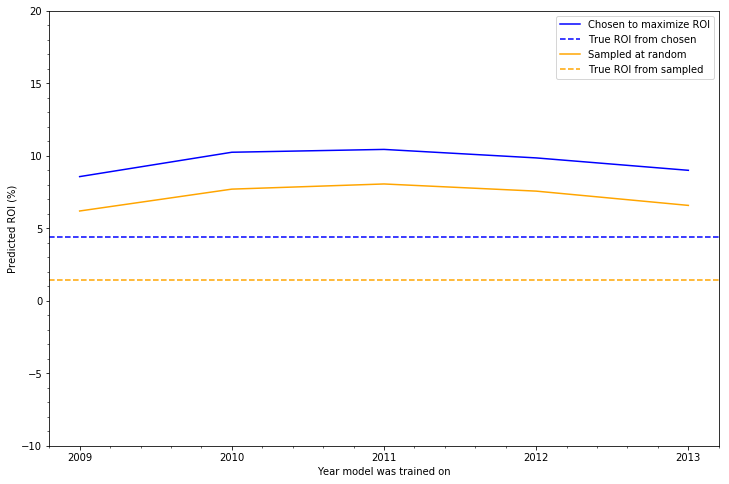

In [20]:
# Number of loans you would like to fund
n = 100

# The loans you would like to examine
df = df_2013[(df_2013['grade_B']==1)]
#df = df_2013[(df_2013['grade_B']==1)|(df_2013['grade_C']==1)]


# Model year you want to use for predicting the highest ROI loans
model = model_2010

r_known_chosen, r_chosen, df_chosen = compare_chosen_loans_to_random_sample(df, n, model)
print 'Chosen loans ranked from highest to lowest expected ROI:'
df_chosen.head()

# What is changing with time?

- The default rate within each grade is increasing with time. 
- LendingClub is possibly loosening its standards within each grade and raising the interest rate to compensate. 
- Should not use grade for time-independent estimate of ROI.

In [167]:
def rate_grade_year(df, year):
    df_new = df[['bad_loan', 'int_rate']].copy()
    
    for col, category in zip(
        ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'], 
        ['A', 'B', 'C', 'D', 'E', 'F', 'G']):
        
        # Convert dummies back to single column of categories
        mask = (df[col]==1)
        df_new.loc[mask, 'grade'] = category
        
    df_new['year'] = year
    
    return df_new

df_new = pd.concat([
    rate_grade_year(df_2009, 2007), 
    rate_grade_year(df_2009, 2008), 
    rate_grade_year(df_2009, 2009), 
    rate_grade_year(df_2010, 2010), 
    rate_grade_year(df_2011, 2011), 
    rate_grade_year(df_2012, 2012), 
    rate_grade_year(df_2013, 2013), 
    rate_grade_year(df_2013, 2014), 
    rate_grade_year(df_2013, 2015), 
])

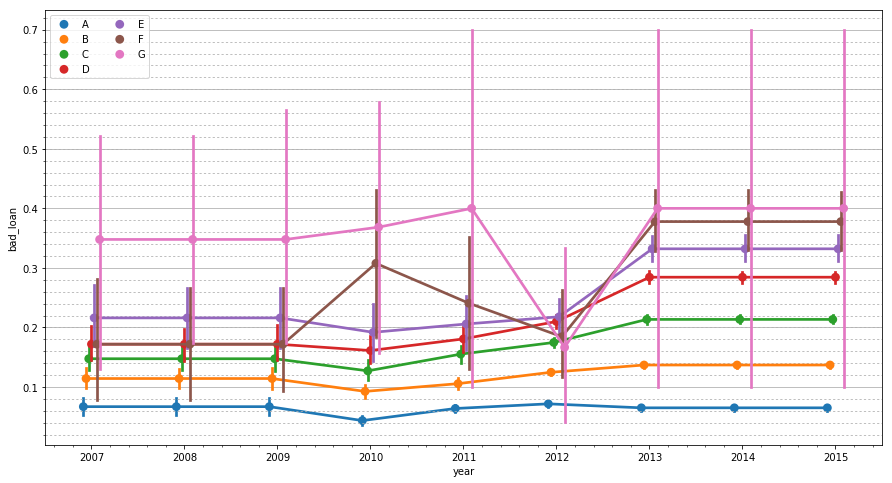

In [168]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(x='year', y='bad_loan', hue='grade', data=df_new, 
              hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], dodge=True, ax=ax)
ax.minorticks_on()
ax.grid(which='major', ls='-', axis='y')
ax.grid(which='minor', ls=':', axis='y')
ax.legend(ncol=2)

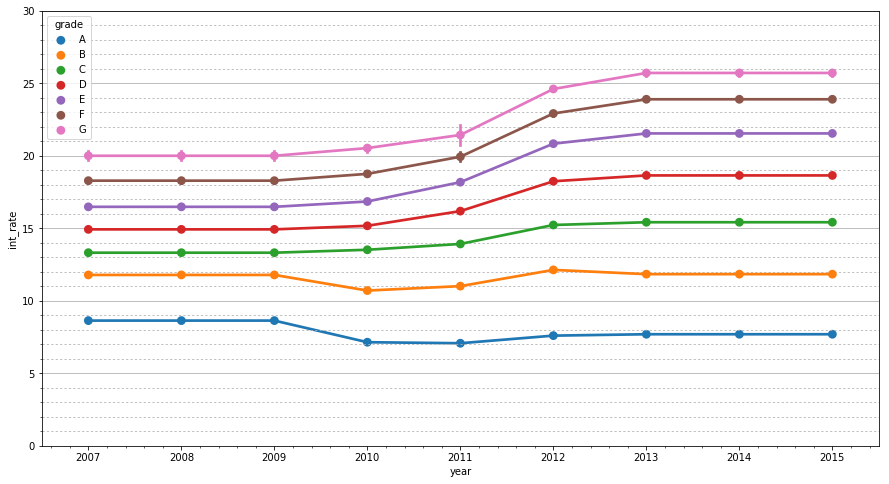

In [169]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.pointplot(x='year', y='int_rate', hue='grade', data=df_new, 
            hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ax=ax)
ax.set_ylim(0, 30)
ax.minorticks_on()
ax.grid(which='major', ls='-', axis='y')
ax.grid(which='minor', ls=':', axis='y')

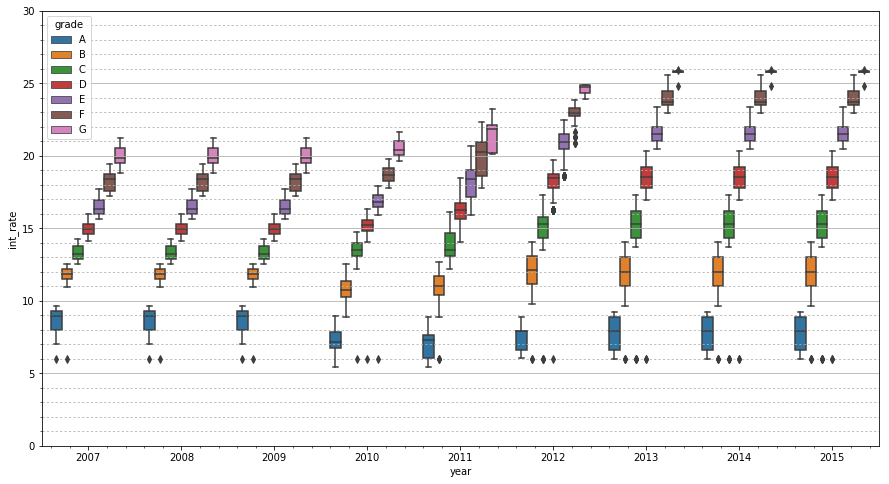

In [170]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(x='year', y='int_rate', hue='grade', data=df_new, 
            hue_order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ax=ax)
ax.set_ylim(0, 30)
ax.minorticks_on()
ax.grid(which='major', ls='-', axis='y')
ax.grid(which='minor', ls=':', axis='y')